In [ ]:
from Automata import Automata
from Controller import Controller
from TAutomata import TAutomata
from utils import *

# Space Specification:

In [9]:
#space=(x1_max, x2_max, x3_range, NX1, NX2, NX3)
space=(10, 10, (-1,1), 50, 50, 15)
#controls = (u1_min, u1_max, u2_min, u2_max, NU1, NU2)
controls = (0.25, 1, -1, 1, 3, 5)
#inputs=(w1,w2,w3,t)
inputs=(0.05,0.05,0.05,1)

# x0_min = 0,0,x3_range[0]
# x0_max = x1_m,x2_m,x3_range[1]
x0_min=(0,0,space[2][0])
x0_max=(space[0],space[1],space[2][1])

In [10]:
def TransFunct(x,u,inputs):
  return ((x[0]+inputs[3]*(u[0]*math.cos(x[2]*math.pi)+inputs[0])),(x[1]+inputs[3]*(u[0]*math.sin(x[2]*math.pi)+inputs[1])),(x[2]+inputs[3]*(u[1]+inputs[2]/math.pi)))

def Dx(u, inputs):
  return np.array([[1, 0, inputs[3]*abs(u[0])],[0, 1, inputs[3]*abs(u[0])],[0, 0, 1]], dtype=float)
def Sx(x_min, x_max, inputs):
  return np.array([(x_max[i] - x_min[i]) / 2 for i in range(3)], dtype=float)
def Xx(x_min, x_max, inputs):
  return np.array([(x_max[i] + x_min[i]) / 2 for i in range(3)], dtype=float)

def Dw(inputs): 
  return np.array([[inputs[3], 0, 0],[0, inputs[3], 0],[0, 0, inputs[3]]], dtype=float)
def Sw(inputs):
  return np.array([inputs[i] for i in range(3)], dtype=float)
def Wx(inputs):
  return [0,0,0]


C:\Users\moham\AppData\Local\Temp\ipykernel_21016\2900350231.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)


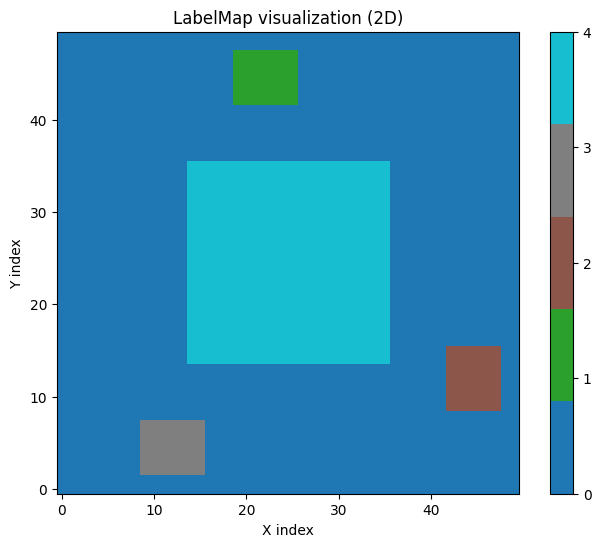

In [ ]:
SpecMap = {
    'a' : {0: 'a', 1: 'b', 2: 'c', 3: 'e', 4: 'e'}, # nothing
    'b' : {0: 'b', 1: 'b', 2: 'e', 3: 'd', 4: 'e'}, # reched R1
    'c' : {0: 'c', 1: 'e', 2: 'c', 3: 'd', 4: 'e'}, # reached R2
    'd' : {0: 'e', 1: 'e', 2: 'e', 3: 'd', 4: 'e'}, # accomplished
    'e' : {0: 'e', 1: 'e', 2: 'e', 3: 'e', 4: 'e'}  # trash
}

accepting_states = ['d']
trash_states = ['e']

Rs = {
  4: (((3.0, 3.0, -1), (7.0, 7.0, 1)),  True),
  3: (((2.0, 0.5, -1), (3.0, 1.5, 1)), False),
  2: (((8.5, 2.0, -1), (9.5, 3.0, 1)), False),
  1: (((4.0, 8.5, -1), (5.0, 9.5, 1)), False),
}

LabelMap , default_states= build_LabelMap(space, x0_min, x0_max, Rs)

import matplotlib.pyplot as plt
import numpy as np

def plot_LabelMap_2D(LabelMap, space):
    """
    Plots a 2D grid showing the label of each cell based on the first two coordinates.
    Ignores the third dimension (z-axis).
    """
    NX1, NX2 = space[3], space[4]
    
    grid = np.zeros((NX1, NX2))  # Initialize a grid
    
    for (i, j, k), label in LabelMap.items():
        grid[i, j] = label  # Only consider first two coordinates
    
    plt.figure(figsize=(8, 6))
    cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)
    im = plt.imshow(grid.T, origin='lower', cmap=cmap, interpolation='nearest')
    plt.colorbar(im, ticks=np.arange(np.max(list(LabelMap.values()))+1))
    plt.xlabel('X index')
    plt.ylabel('Y index')
    plt.title('LabelMap visualization (2D)')
    plt.show()

# Call the function
plot_LabelMap_2D(LabelMap, space)

# Generation

In [ ]:
skip = False
h = {}  # Symbolic controller mapping state -> list of valid controls

try:
    import pickle
    with open("controller_h.pkl", "rb") as f:
        h = pickle.load(f)
    skip = True
    print(f"Loaded controller with {len(h)} states")
except:
    skip = False
    print("No saved controller found, will generate new one")

In [ ]:
if not skip:
    # step 1: generate the TransitionMap and define the automata
    Tmap = TransMap(x0_min, x0_max, controls, inputs, space, TransFunct, Dx, Dw, Sx, Sw, Xx, Wx)

In [ ]:
if not skip:
    # 2. Build symbolic controller h using reachability on product automaton
    from ProdAutomata import ProdAutomata
    
    # Create TAutomata from Tmap
    Tautomata = TAutomata(Tmap)
    
    # Create ProdAutomata
    ProductAutomata = ProdAutomata(
        TAutomata=Tautomata,
        SpecMap=SpecMap,
        label_map=LabelMap,
        default_states=default_states,
        accept_spec_states=accepting_states
    )
    
    print(f"Product automaton created with {len(Tmap)} system states")

In [ ]:
if not skip:
    # 3. Apply reachability to compute controller h
    # h maps product states (sys_state, spec_state) -> list of valid controls
    
    h = {}
    R = set(ProductAutomata.accept_states)
    print(f"Starting reachability from {len(R)} accepting states")
    
    iteration = 0
    while True:
        # Compute predecessors
        actual_pred = ProductAutomata.predecessor_func(R)
        
        # Update h with valid controls
        for (state, control) in actual_pred:
            if state not in h:
                h[state] = []
            if control not in h[state]:
                h[state].append(control)
        
        # Update reachable set
        R_new = R.union(set(state for state, _ in actual_pred))
        
        if R_new == R:
            break
        R = R_new
        iteration += 1
        if iteration % 10 == 0:
            print(f"Iteration {iteration}: {len(R)} reachable states")
    
    print(f"Reachability converged after {iteration} iterations")
    print(f"Controller h has {len(h)} states with valid controls")

In [ ]:
if not skip:
    # 4. Save controller h
    import pickle
    with open("controller_h.pkl", "wb") as f:
        pickle.dump(h, f)
    print("Controller saved to controller_h.pkl")

# Visualisation

In [ ]:
# Helper functions for concrete simulation

def generate_disturbance(inputs):
    """Generate random disturbance w within bounds"""
    w1 = np.random.uniform(-inputs[0], inputs[0])
    w2 = np.random.uniform(-inputs[1], inputs[1])
    w3 = np.random.uniform(-inputs[2], inputs[2])
    return (w1, w2, w3)

def discrete_to_concrete_control(discrete_control_idx, controls):
    """Convert discrete control index to concrete control value"""
    CntD = ControlD(controls)
    return CntD[discrete_control_idx]

def get_discrete_control_index(u, controls):
    """Find the index of control u in the discrete control set"""
    CntD = ControlD(controls)
    for idx, control in enumerate(CntD):
        if np.allclose(control, u, atol=1e-9):
            return idx
    return None

Text(0.5, 1.0, '10 random symbolic trajectories\n(start = green, end = red)')

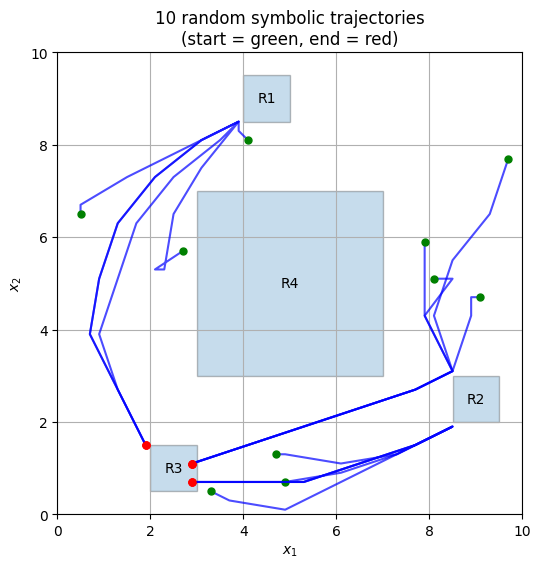

In [ ]:
# ============================================================
#   CONCRETE SIMULATION WITH CONTROLLER h
# ============================================================
import random
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
N_traj = 5  # Number of trajectories
max_steps = 200  # Maximum steps per trajectory

# Prepare figure
fig, ax = plt.subplots(figsize=(8, 6))

# Draw regions R1–R4
for label, ((rmin, rmax), intersect) in Rs.items():
    xmin, ymin = rmin[0], rmin[1]
    xmax, ymax = rmax[0], rmax[1]
    width, height = xmax - xmin, ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height,
                         alpha=0.25, edgecolor='k')
    ax.add_patch(rect)
    ax.text((xmin+xmax)/2, (ymin+ymax)/2, f"R{label}",
            ha='center', va='center', fontsize=10)

# Run concrete simulations
for traj_idx in range(N_traj):
    # Pick random starting state from default_states
    start_cell = random.choice(default_states)
    start_spec = 'a'
    
    # Initialize continuous state x at center of start cell
    x = np.array(cell_center(start_cell, space))
    
    # Initialize control u to first available control (index 0)
    u_idx = 0
    u = discrete_to_concrete_control(u_idx, controls)
    
    # Store trajectory for plotting
    trajectory = [x.copy()]
    
    # Simulation loop
    for step in range(max_steps):
        # 1. Generate random disturbance w
        w = generate_disturbance(inputs)
        
        # 2. Calculate f(x, u, w) to get x+
        inputs_with_w = (w[0], w[1], w[2], inputs[3])
        x_next = np.array(TransFunct(tuple(x), tuple(u), inputs_with_w))
        
        # 3. Set x to x+
        x = x_next
        
        # Check if x is out of bounds
        if not (0 <= x[0] <= space[0] and 0 <= x[1] <= space[1] and 
                space[2][0] <= x[2] <= space[2][1]):
            break
        
        # 4. Determine discretization of x: e (cell)
        e = continuous_to_cell(tuple(x), space)
        
        # Determine current specification state based on label
        label = LabelMap.get(e, 0)
        current_spec = start_spec  # Track spec state through trajectory
        
        # Get product state
        product_state = (e, current_spec)
        
        # 5. Using h[product_state], determine next discrete control c
        if product_state in h and len(h[product_state]) > 0:
            # Pick a valid control (random choice if multiple)
            u_idx = random.choice(h[product_state])
            
            # 6. Determine concrete control u+ from discrete control index
            u = discrete_to_concrete_control(u_idx, controls)
            
            # Update specification state based on transition
            start_spec = SpecMap[current_spec][label]
        else:
            # No valid control available, trajectory fails
            break
        
        # 7. Set u to u+ and loop
        trajectory.append(x.copy())
        
        # Check if we reached accepting state
        if start_spec in accepting_states:
            break
    
    # Plot trajectory
    trajectory = np.array(trajectory)
    ax.plot(trajectory[:, 0], trajectory[:, 1], '-', alpha=0.7, linewidth=1.5)
    
    # Mark start (green) and end (red)
    ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=8)
    ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=8)

# Final plot formatting
ax.set_xlim(0, space[0])
ax.set_ylim(0, space[1])
ax.set_xlabel(r'$x_1$', fontsize=12)
ax.set_ylabel(r'$x_2$', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_title(f"{N_traj} Concrete Trajectories with Controller h\n(start = green, end = red)", fontsize=12)
plt.tight_layout()
plt.show()